# Project: Investigate a Dataset: Titanic

Dataset contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. Dataset has been obtained from [Kaggle website](https://www.kaggle.com/c/titanic/data). The following information was provided with the dataset:

### Data Dictionary


|Variable|Definition|Key|
|-|-|-|
|survival|Survival|0= No, 1 = Yes|
|pclass|Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation||

### Variable Notes

**pclass**: A proxy for socio-economic status (SES)  
- 1st = Upper
- 2nd = Middle
- 3rd = Lower


**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...  
*Sibling* = brother, sister, stepbrother, stepsister  
*Spouse* = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...  
*Parent* = mother, father  
*Child* = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore *parch=0* for them.

### Questions:

- How do the following factors impact survival:
    - Age/gender
    - Socio-economic status
    - Family situation
    - Cabin location

# Imports and Functions

In [1]:
# importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
import seaborn as sns
import scipy.stats as stats

In [2]:
# config
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set_context('paper')

# seaborn xkcd color palette
colors = ['greyish','amber','faded green','dusty purple','windows blue']
sns.set_palette(sns.xkcd_palette(colors))

In [3]:
# All functions that will be used for this analysis

# age groups
# here we decided to only split by children and adults
# so we can later apply Fisher's test
def age_group(age):
    if age < 18:
        return 'child'
    else:
        return 'adult'

    
#  family status
def family(rec):
    if rec:
        return 'family'
    else:
        return 'single'


# deck location of cabin
def deck(rec):
    return rec[0]


# independent 2-sample t test using function from scipy, assuming samples do not have equal variances
# accepted input parameters:
    # data = dataset
    # col1 = factor by which we group data
    # col2 = continuous factor (e.g. Age)
    # f1 and f2 = variant of the grouping factor.
def ttest(data, col1, col2, gr1, gr2):
    group1 = data.groupby(col1).get_group(gr1)[col2]
    group2 = data.groupby(col1).get_group(gr2)[col2]
    tstat, pvalue = stats.ttest_ind(group1,group2,equal_var=False)
    return 't-statistic: {}, p-value: {}'.format(tstat.round(3),pvalue)


# fisher exact test: data=dataset, factor=column_name 
def fisher(data,factor):
    survived = data[data['Survived']==1]
    died = data[data['Survived']==0]
    
    survived_count =  survived.groupby(factor)[factor].count()
    died_count = died.groupby(factor)[factor].count()
    
    table =  pd.DataFrame({'survived':survived_count,'died':died_count})
    print table
    
    oddsratio, pvalue = stats.fisher_exact(table)
    return 'Odds Ratio: {}, p-value: {}'.format(oddsratio.round(3), pvalue)

# Data overview

In [4]:
# read data from csv
titanic = pd.read_csv('titanic-data.csv')

In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Duplicates

In [7]:
# check for duplicates
duplicates = titanic.duplicated()
print 'There are {} duplicates in dataset'.format(duplicates.sum())

There are 0 duplicates in dataset


### Missing data

In [8]:
# check for missing data in dataset
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Some information included in the dataset will not be used in this analysis, and can be safely deleted.
The following columns will be removed: PassengerId, Name, Ticket, Fare, Embarked.

Of the data that will be retained for analysis, Age and Cabin records are incomplete. New datasets will be created, corrected for missing values in Age and Cabin columns, the rows with missing data will be ommited. Additional Family column will be added that will summarise family status of passengers.

# Data cleanup

In [9]:
# remove columns deemed unnecessary for further analysis
titanic = titanic.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Embarked'], axis=1)

In [10]:
# create Family column
titanic.loc[:,'Family'] = (titanic.SibSp+titanic.Parch).apply(family)

In [12]:
# create Survival label column
titanic['Survival'] = titanic.Survived.map({0 : 'died', 1 : 'survived'})
# create Class label column
titanic['Class'] = titanic.Pclass.map({1 : 'first class', 2 : 'second class', 3 : 'third class'})

In [13]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family,Survival,Class
0,0,3,male,22.0,1,0,NaN,family,died,third class
1,1,1,female,38.0,1,0,C85,family,survived,first class
2,1,3,female,26.0,0,0,NaN,single,survived,third class
3,1,1,female,35.0,1,0,C123,family,survived,first class
4,0,3,male,35.0,0,0,NaN,single,died,third class


In [14]:
# remove empty Age records, new dataset created
titanic_age = titanic[pd.notnull(titanic.Age)]

In [16]:
# add age group column
titanic_age.loc[:,'AgeGroup'] = titanic_age.Age.apply(age_group)

In [17]:
titanic_age.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family,Survival,Class,AgeGroup
0,0,3,male,22.0,1,0,NaN,family,died,third class,adult
1,1,1,female,38.0,1,0,C85,family,survived,first class,adult
2,1,3,female,26.0,0,0,NaN,single,survived,third class,adult


In [18]:
# removing empty Cabin records, new dataset created
titanic_cabin = titanic[pd.notnull(titanic.Cabin)]

# change cabin records to deck records
titanic_cabin.loc[:,'Cabin'] = titanic_cabin.Cabin.apply(deck)

In [19]:
titanic_cabin.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family,Survival,Class
1,1,1,female,38.0,1,0,C,family,survived,first class
3,1,1,female,35.0,1,0,C,family,survived,first class
6,0,1,male,54.0,0,0,E,single,died,first class


# Data exploration

### Overall survival

(-1.0121714842837193,
 1.1129644124301212,
 -1.0100265976564469,
 1.0356886771260456)

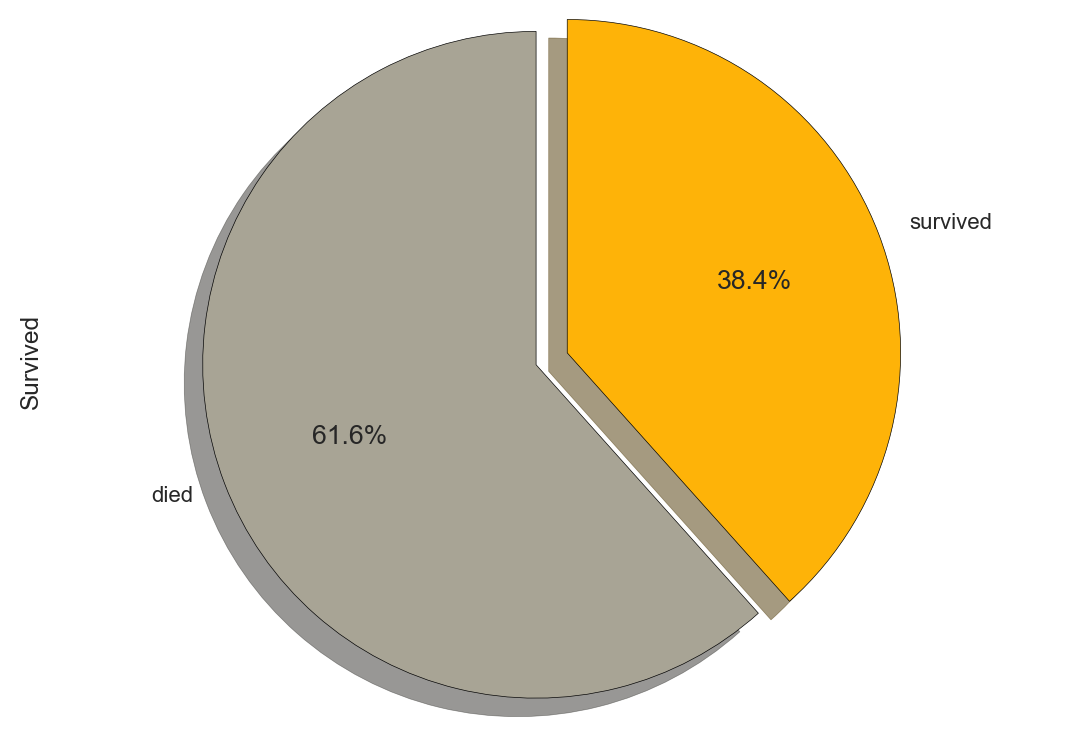

In [20]:
labels = 'died', 'survived'
survivalpie = titanic.Survived.value_counts().plot.pie(labels=labels, autopct='%1.1f%%',shadow=True,
                                                         startangle=90, explode=(0,0.1))
survivalpie.axis('equal')

Only 38.4% of all passengers included in the available dataset survived sinking of the Titanic. Let's now look at survivability by age, gender, socio-economic class, and company of family.

# Survival rate by Age

### Age disrtibution

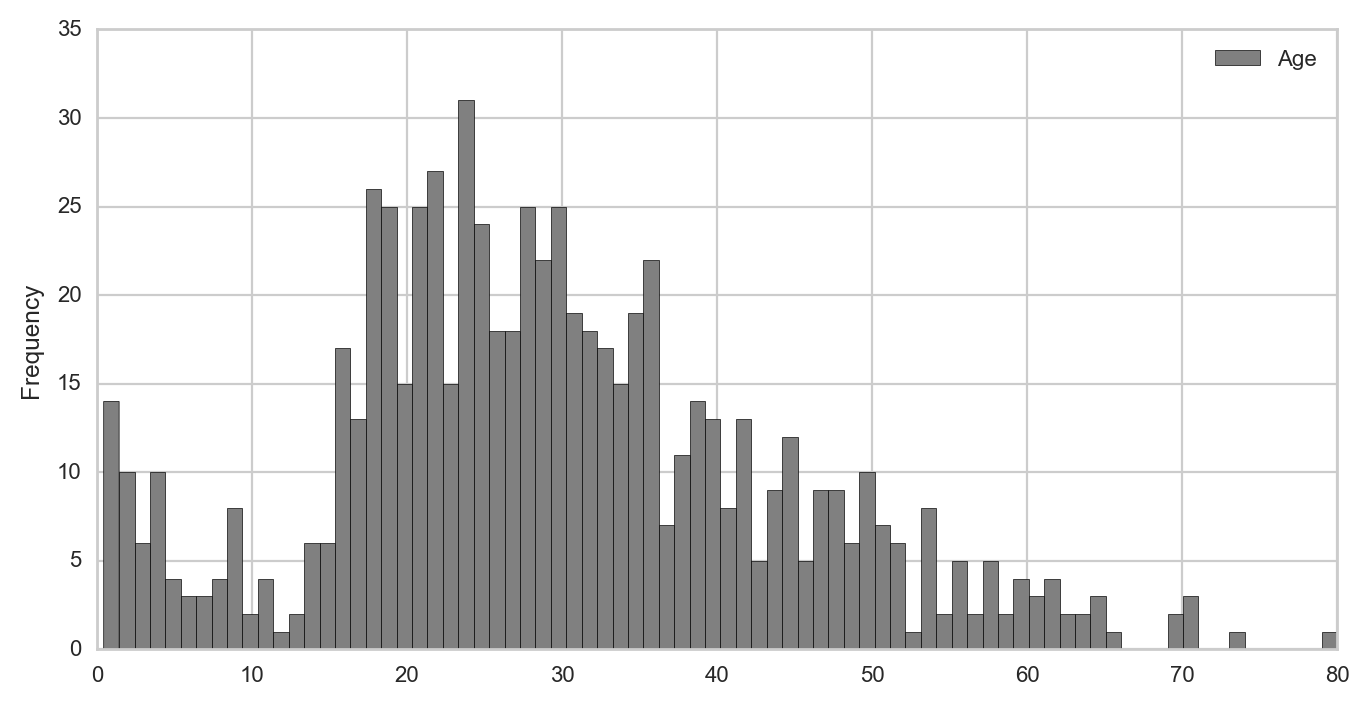

In [21]:
# age distribution
titanic_age.Age.plot.hist(bins=80, legend=True, figsize = (8,4), color='grey')

In [22]:
print 'Age distribution:\nmean:\n{}\nmedian:\n{}'.format(titanic.Age.mean().round(1)
                                                         ,titanic.Age.median())

Age distribution:
mean:
29.7
median:
28.0


Age distribution is positively skewed, which is visible on the age distribution chart. Calculated mean age and median age further support this observation with median age being lower than mean.

### Probability of survival by age

To assess statistical significance of age for survival, we are going to perform two tailed t-test.

- H<sub>0</sub> - there is no significant difference in age means between survivors and people who died
- H<sub>A</sub> - there is significant difference in age means between survivors and people who died

For our samples, t-critical value is 1.96<sup>[1](http://snobear.colorado.edu/Markw//IntroHydro/12/statistics/testchart.pdf)</sup>

In [23]:
ttest(titanic_age,'Survival','Age','died','survived')

't-statistic: 2.046, p-value: 0.0411896516259'

We can reject the null hypothesis, and the result is statistically significant with p<.05

In [24]:
print 'Age distribution:\nAge Mean by:\n{}\nAge Median by:\n{}'.format(titanic_age.groupby('Survived').Age.mean()
                                   ,titanic_age.groupby('Survived').Age.median())

Age distribution:
Age Mean by:
Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64
Age Median by:
Survived
0    28.0
1    28.0
Name: Age, dtype: float64


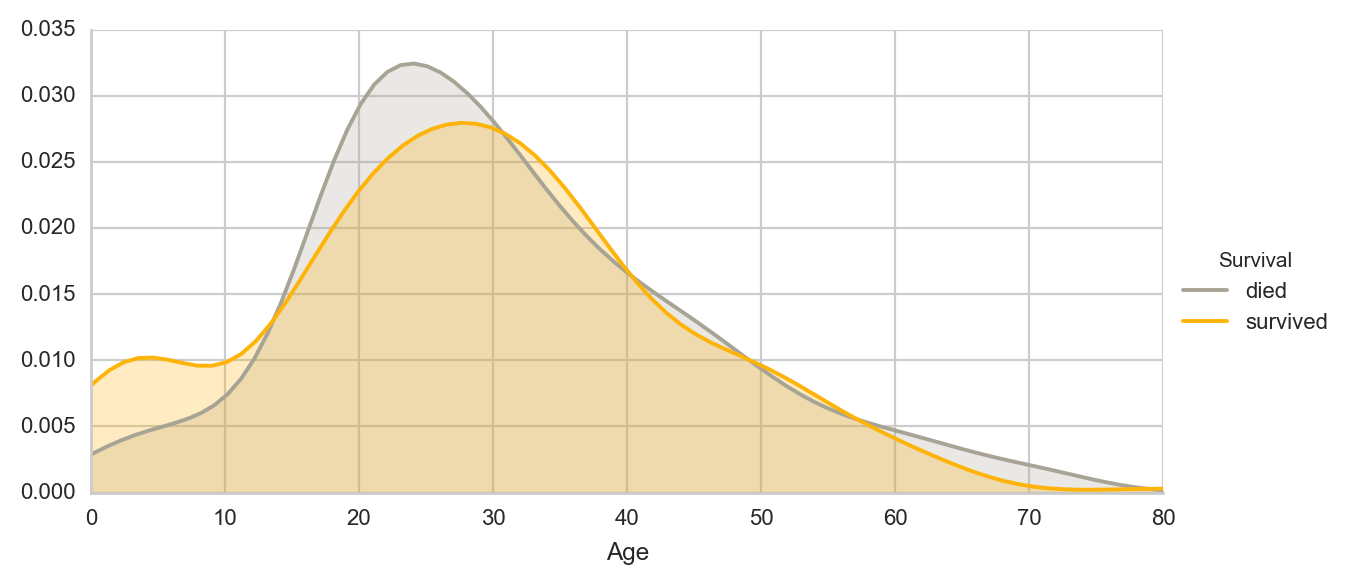

In [25]:
# distributions for survived and died groups by age.
a = sns.FacetGrid(titanic_age, hue='Survival',size=3, aspect=2)
a.map(sns.kdeplot,'Age', shade=True)
a.set(xlim=(0,titanic['Age'].max()))
a.add_legend()

### Survival by age group

AgeGroup
adult    0.381
child    0.540
Name: Survived, dtype: float64

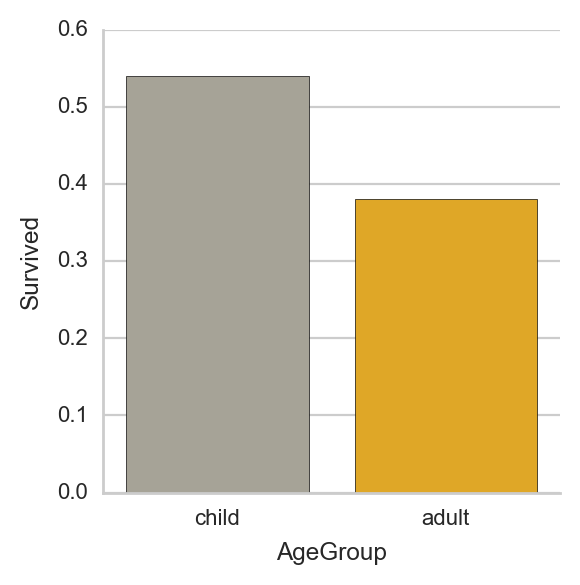

In [26]:
sns.factorplot('AgeGroup','Survived', data=titanic_age,
               order=['child','adult'],
               kind='bar', size=3,ci=False)

titanic_age.groupby('AgeGroup').Survived.mean().round(3)

Comparing survivability by age group we can see trend with 54% children surviving, 38,1% of adults. To calculate if difference in survival is statistically significant we will use Fisher's test. Because we are comparing two groups (male, female), and outcome has two possibilities (died, survived), we cannot use t-test.<sup>[2](https://www.graphpad.com/guides/prism/6/statistics/index.htm?stat_qa_choosing_a_test_to_compare_.htm)</sup>

In [27]:
fisher(titanic_age,'AgeGroup')

          died  survived
AgeGroup                
adult      372       229
child       52        61


'Odds Ratio: 1.906, p-value: 0.00235403714062'

The odds of child surviving is 1.906 times that of an adult surviving, and the reault is statistically significant with p <.05

# Survival rate by Gender

### Gender dostribution

Sex
female    314
male      577
Name: Sex, dtype: int64

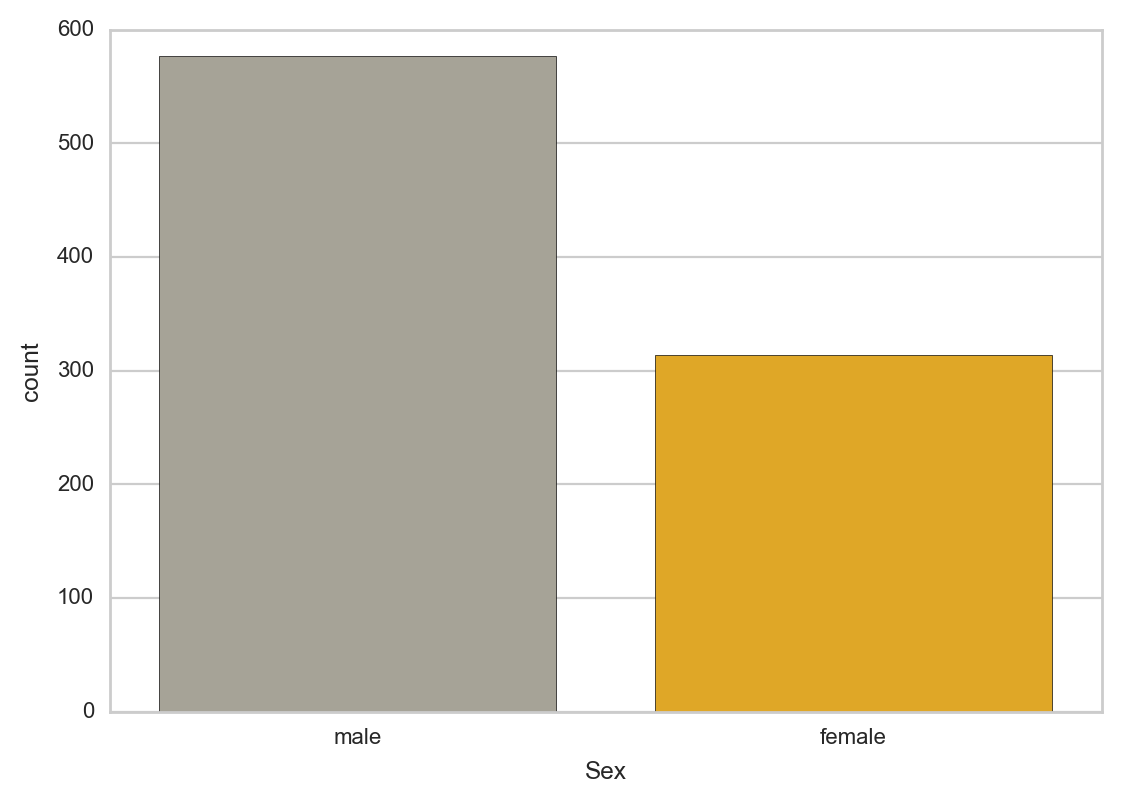

In [28]:
sns.countplot('Sex',data=titanic)
titanic.groupby('Sex').Sex.count()

Majority of passengers included in the dataset are young adults, and the age distribution is not much different between men and women, with women being on average a little younger than men.

### Age distribution by gender

Age distribution:
Age Mean by:
Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64
Age Median by:
Sex
female    27.0
male      29.0
Name: Age, dtype: float64


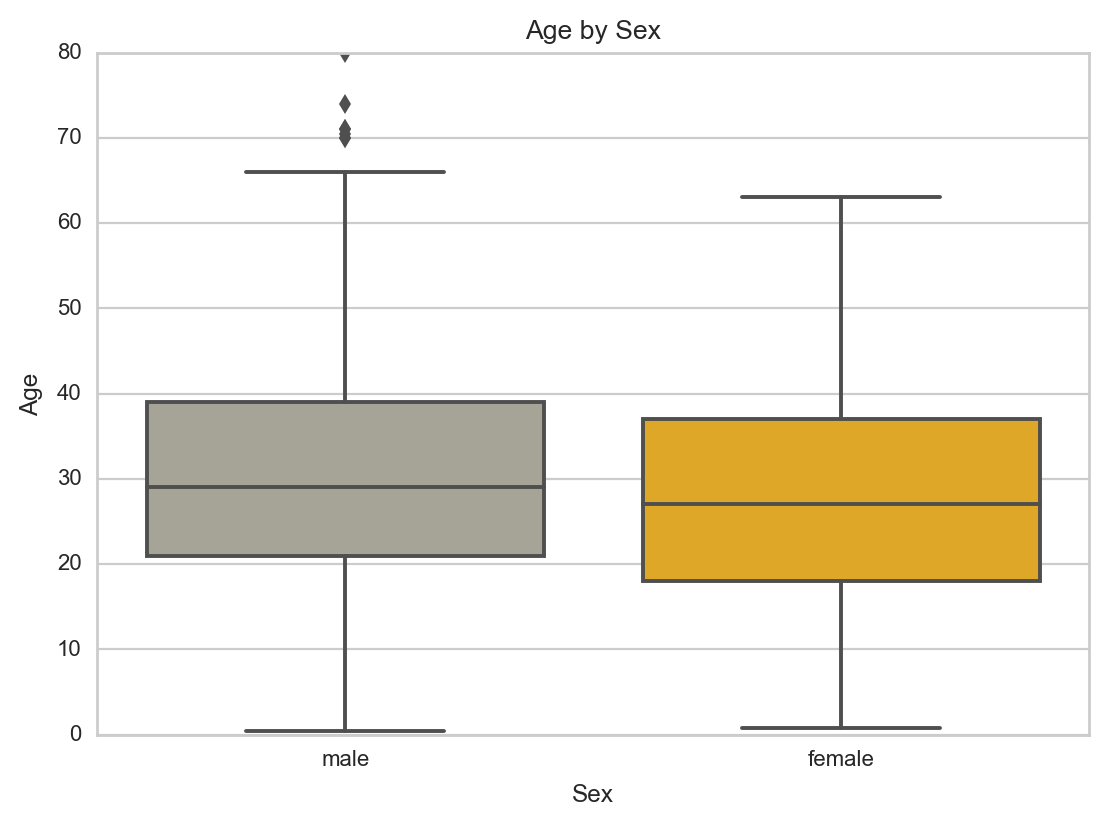

In [30]:
agesex = sns.boxplot(data=titanic_age, x= 'Sex', y = 'Age')
agesex.set(title='Age by Sex')

print 'Age distribution:\nAge Mean by:\n{}\nAge Median by:\n{}'.format(titanic_age.groupby('Sex').Age.mean()
                                   ,titanic_age.groupby('Sex').Age.median())

To compare if there is statistically significant age differences between males and females we are going to perform a t-test

- H<sub>0</sub> - there is no significant difference between age means for males and females
- H<sub>A</sub> - there is significant difference in age means between males and females

t-critical value=1.96

In [31]:
ttest(titanic_age,'Sex','Age','male','female')

't-statistic: 2.526, p-value: 0.0118149132119'

We can reject the null hypothesis, with p<.05.

### Probability of survival by gender

Sex
female    0.742
male      0.189
Name: Survived, dtype: float64

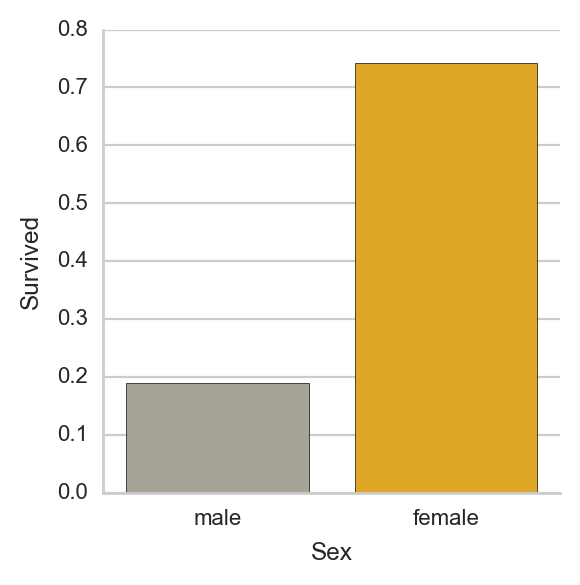

In [32]:
sns.factorplot('Sex','Survived', data=titanic,
               kind='bar', size=3,ci=False)
# percentage of survivors by gender
titanic.groupby('Sex').Survived.mean().round(3)

Only 18,9% males and as much as 74,2% females survived. To see if difference in survival by gender is statistically significant, we can perform Fisher exact test.

In [33]:
fisher(titanic,'Sex')

        died  survived
Sex                   
female    81       233
male     468       109


'Odds Ratio: 0.081, p-value: 6.46392156458e-60'

The odds of male surviving is 0.081 times that of female surviving, and the reault is statistically significant with p <.05

# Survival rate by Class

### Passenger distribution by class

Class
first class     216
second class    184
third class     491
Name: Class, dtype: int64

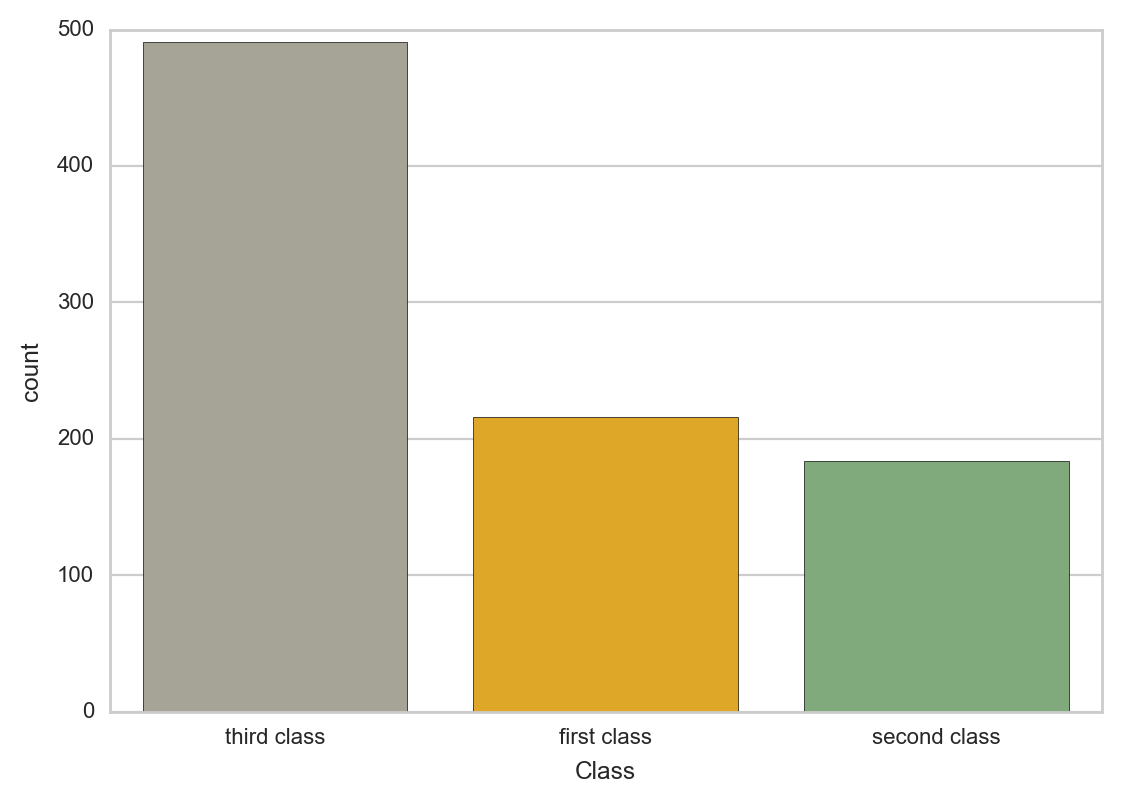

In [34]:
sns.countplot('Class',data=titanic)

# passenger distribution by class count
titanic.groupby('Class').Class.count()

### Passenger gender distribution by class

              male  male%  female  female%  total  total%
Class                                                    
first class    122   0.21      94     0.30    216    0.24
second class   108   0.19      76     0.24    184    0.21
third class    347   0.60     144     0.46    491    0.55


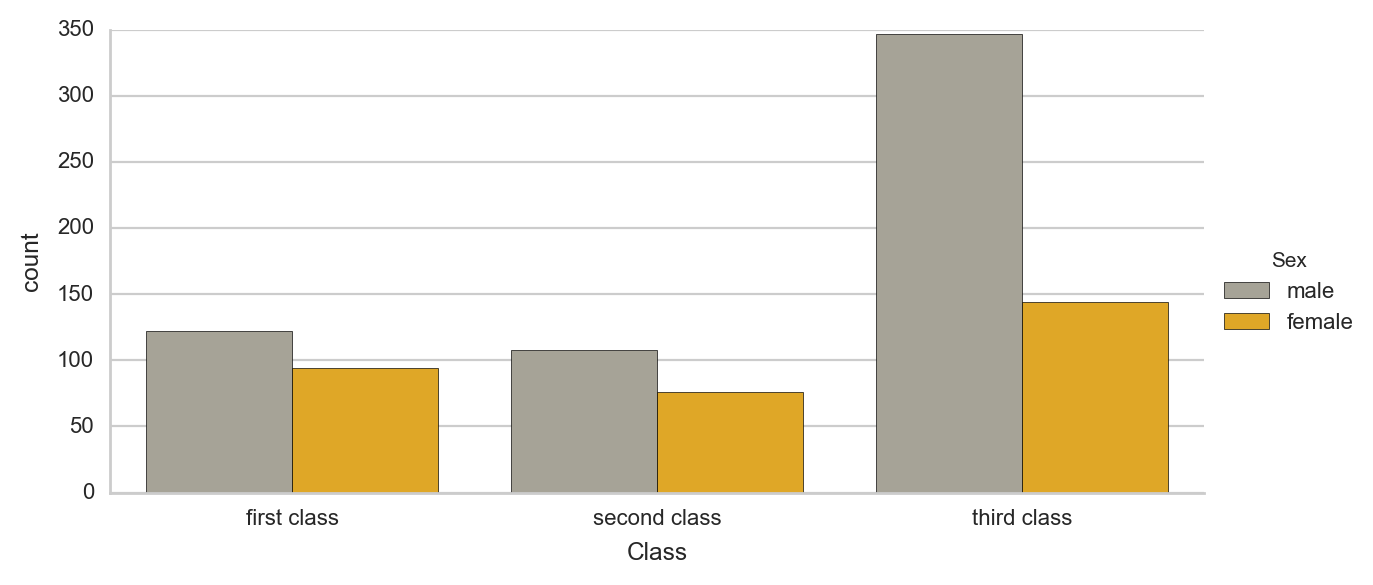

In [35]:
sns.factorplot('Class', data=titanic, hue='Sex', order=['first class','second class','third class'],
               hue_order=['male','female'], kind='count', size=3, aspect=2)


# pasesnger gender distribution by class table
passenger_count = titanic.groupby('Class').Sex.count()

male = titanic[titanic.Sex=='male']
female = titanic[titanic.Sex=='female']

male_count = male.groupby('Class').Class.count()
female_count = female.groupby('Class').Class.count()

count = male_count.to_frame(name='male')
count['male%'] = (male_count/male_count.sum()).round(2)
count['female'] = female_count
count['female%'] = (female_count/female_count.sum()).round(2)
count['total'] = passenger_count
count['total%'] = (passenger_count/passenger_count.sum()).round(2)
print count

Women are more equally distributed among different classe than men. 55% of all passengers are in 3rd class with disproportionately more men, than women. Passengers in 1st and 2nd class are more equally distributed by both counts and gender.

### Passenger age distribution by class

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

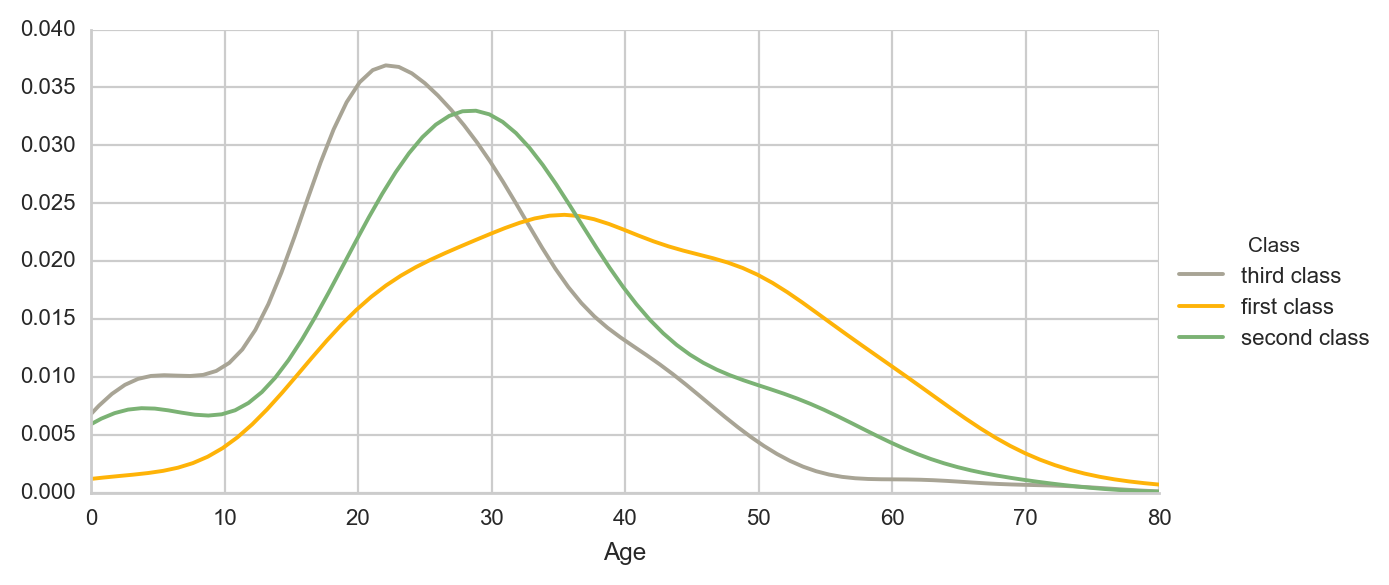

In [37]:
# passenger age in different classes
a = sns.FacetGrid(titanic_age, hue='Class',size=3, aspect=2)
a.map(sns.kdeplot,'Age')
a.set(xlim=(0,titanic.Age.max()))
a.add_legend()

# mean age in different classes
titanic.groupby('Pclass').Age.mean()

Passengers in 1st class have highest median age, followed by 2nd and 3rd class, respectivelly. Age distribution in 1st class is also more flat than 2nd and 3rd.

### Survival by Class

Class
first class     0.630
second class    0.473
third class     0.242
Name: Survived, dtype: float64

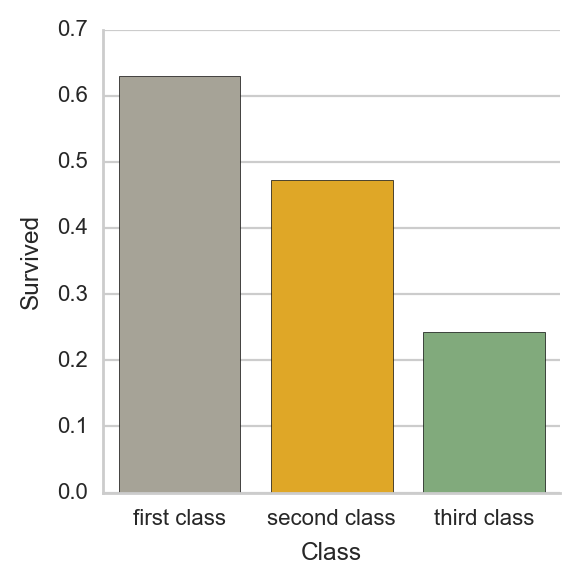

In [38]:
sns.factorplot('Class','Survived', data=titanic,
               order=['first class','second class','third class'],
               kind='bar', size=3, ci=False)

# percentage of survivors by class
titanic.groupby('Class').Survived.mean().round(3)

The highest fraction of passengers survived in 1st class (63%), followed by 2nd class (47,3%), the lowest survival was in 3rd class, only 24,2%.

### Survival by class for different genders

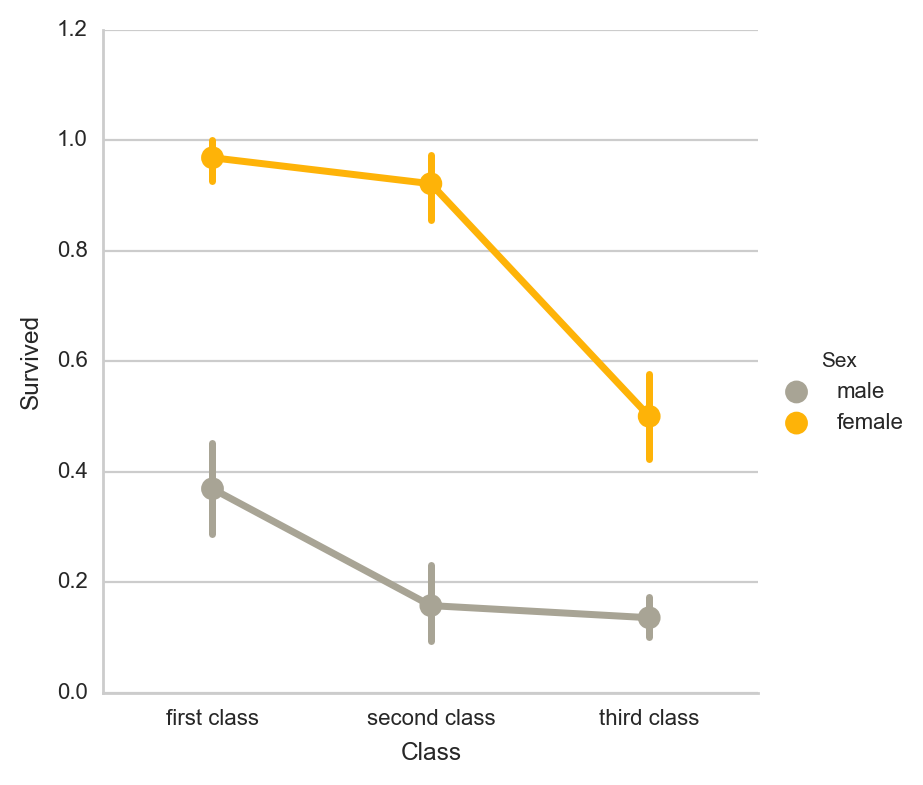

In [39]:
sns.factorplot('Class', 'Survived', hue='Sex',
               order=['first class','second class','third class'],
               data=titanic, kind='point')

For both men and women the same trend in declining survival rate with lower class is observed. Survival rate for women in any class is higher than survival rate for men. Women in 1st and 2nd class had overall high survival rate, and survival rate decreases rapidly in 3rd class, whereas men had overall low survival rates, with biggest drop in survival rate between 1st and 2nd class.

### Survival by class - age distribution

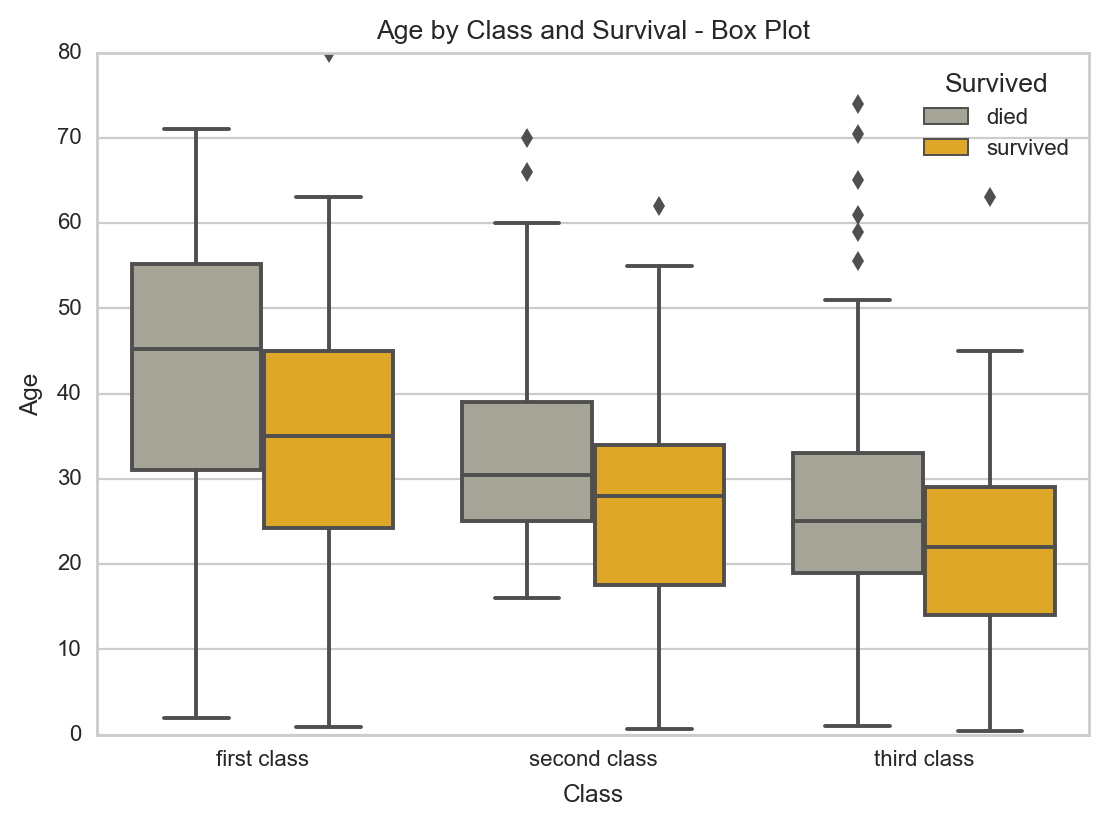

In [40]:
s = sns.boxplot(data=titanic_age, x= 'Class', y = 'Age', hue='Survival',
                order=['first class','second class','third class'])
s.set(title='Age by Class and Survival - Box Plot')
s.legend(title='Survived')

Mean age of survivors for given class was lower than mean age of the passengers who died.

For every class we can test if there is significant mean age difference:

- H<sub>0</sub> - there is no significant difference between age means for passengers that survived and died
- H<sub>A</sub> - there is significant difference between age means for passengers that survived and died


In [44]:
# 1st class
# t-ctirical = 1.97
titanic_c1 = titanic_age[titanic_age.Class=='first class']
ttest(titanic_c1,'Survival','Age','died','survived')

't-statistic: 3.651, p-value: 0.00039205429111'

In [45]:
# 2nd class
# t-critical = 1.97
titanic_c2 = titanic_age[titanic_age.Class=='second class']
ttest(titanic_c2,'Survival','Age','died','survived')

't-statistic: 3.689, p-value: 0.000309204810314'

In [46]:
# 3rd class
# t-critical = 1.96
titanic_c3 = titanic_age[titanic_age.Class=='third class']
ttest(titanic_c3,'Survival','Age','died','survived')

't-statistic: 3.934, p-value: 0.000129303001841'

For every class we can reject null hypothesis, and we can say there is statisticaly significant mean age difference between passengers who survived and died, with p<.05

# Survival by family status

Family
family    354
single    537
Name: Family, dtype: int64

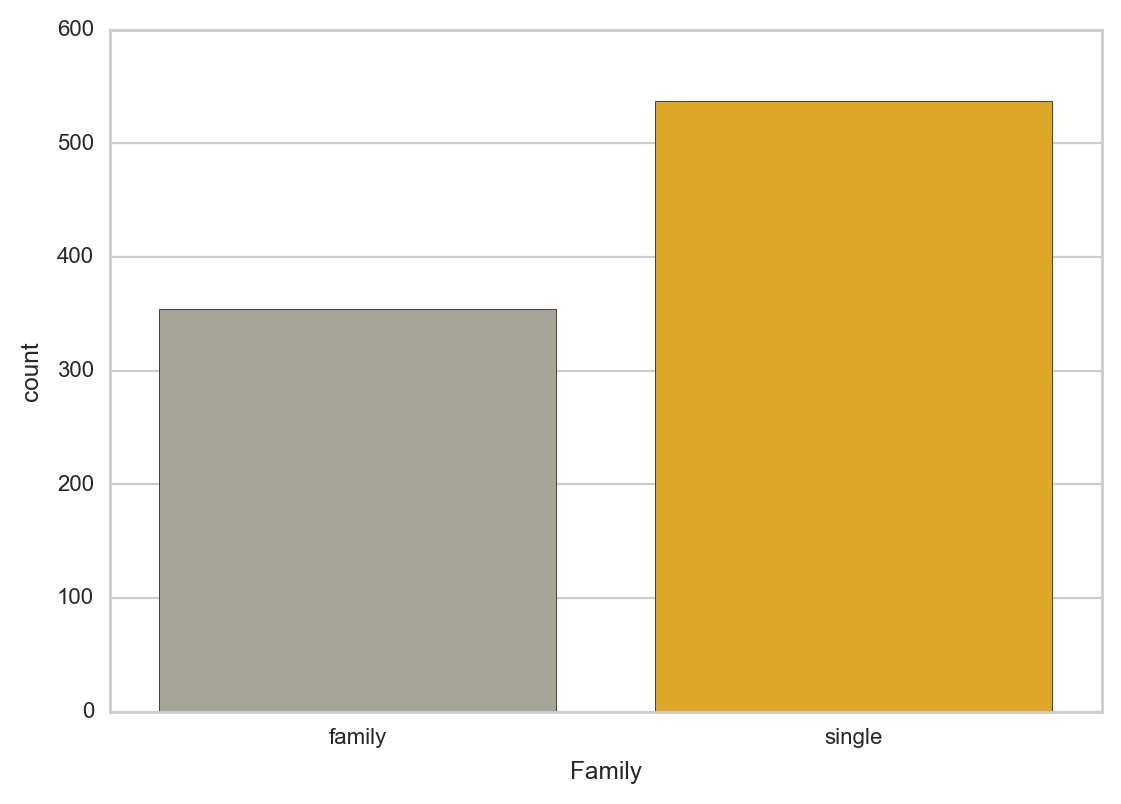

In [47]:
sns.countplot('Family',data=titanic)

# passenger count by family status
titanic.groupby('Family').Family.count()

Family
family    0.506
single    0.304
Name: Survived, dtype: float64

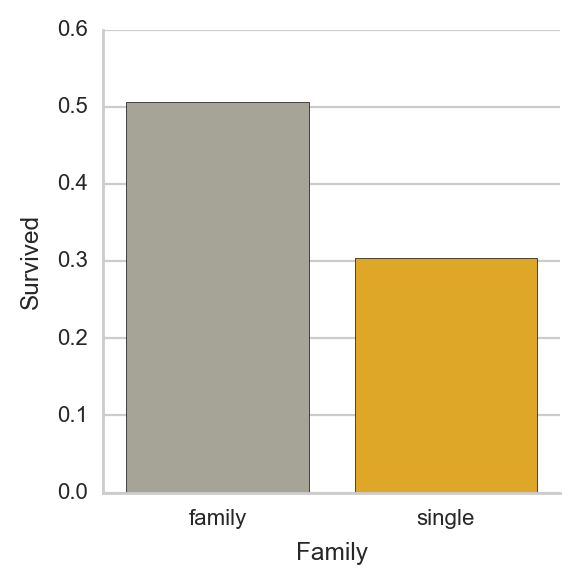

In [48]:
sns.factorplot('Family','Survived', data=titanic,
               kind='bar', size=3,ci=False)

# percentage of survivors by family status
titanic.groupby('Family').Survived.mean().round(3)

In [49]:
fisher(titanic,'Family')

        died  survived
Family                
family   175       179
single   374       163


'Odds Ratio: 0.426, p-value: 1.8571820806e-09'

The odds of single passengers surviving is 0.426 times that of an passengers with family, and the reault is statistically significant with p <.05

### Passenger survival by family status for separate genders

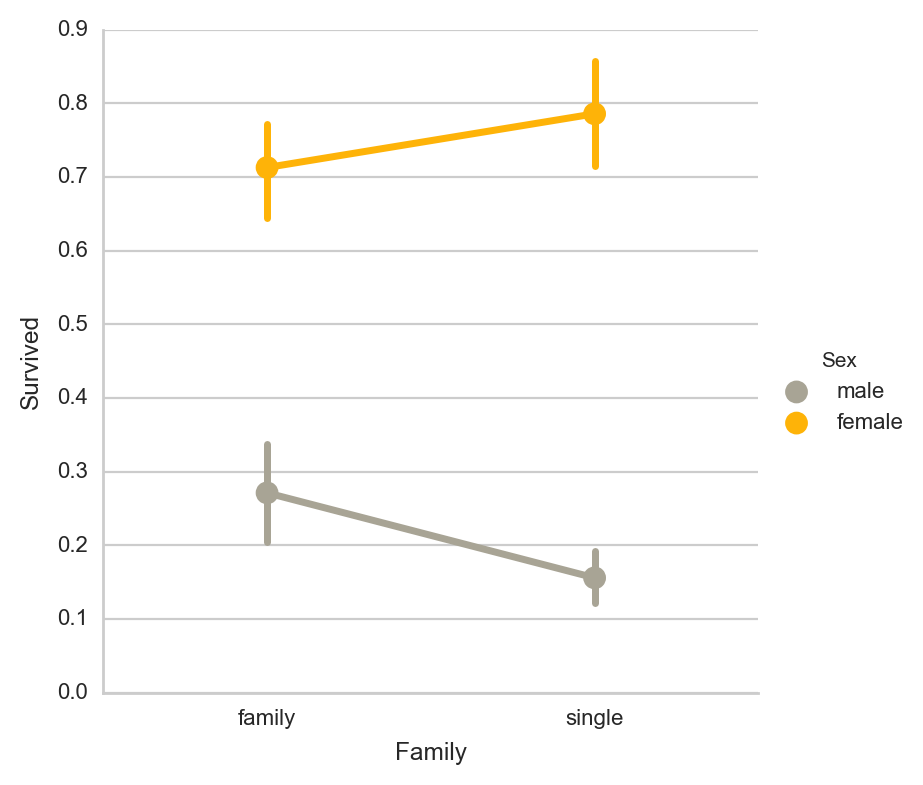

In [50]:
sns.factorplot('Family', 'Survived', hue='Sex',
               data=titanic, kind='point')

Interestingly, when we look at genders separately, single women have higher survival rates than men.

# Survival by deck

### Passengers distribution by deck and gender

Cabin
A    15
B    47
C    59
D    33
E    32
F    13
G     4
T     1
Name: Cabin, dtype: int64

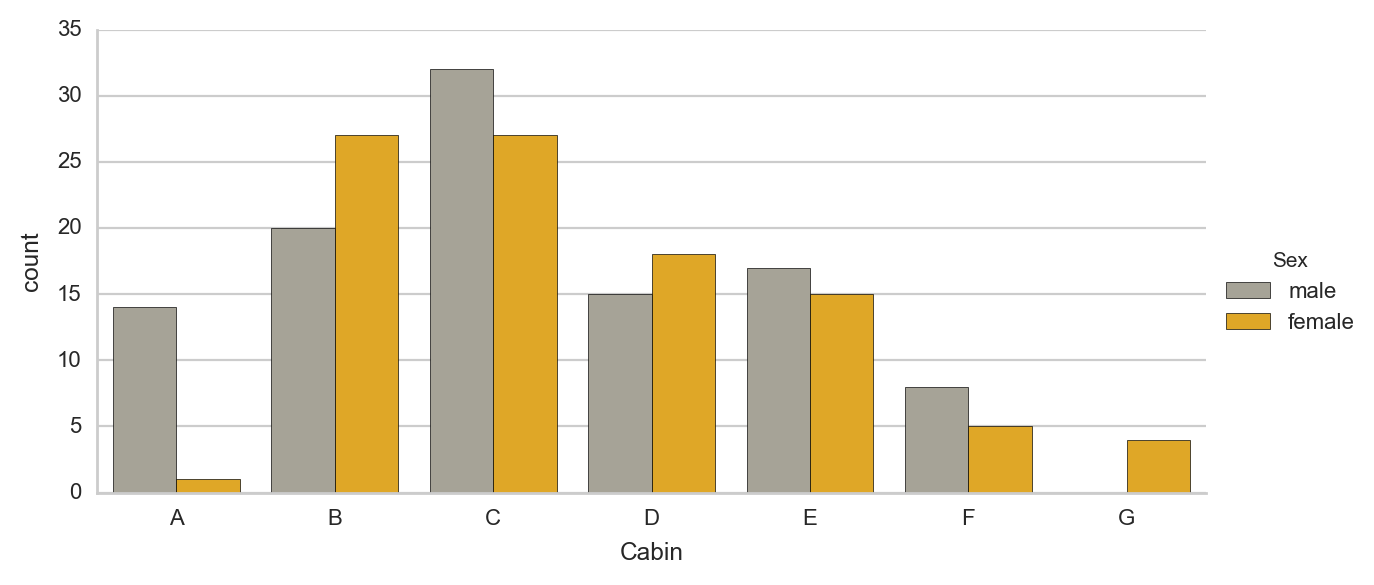

In [51]:
# Passenger gender distribution on the decks
sns.factorplot('Cabin', data=titanic_cabin, hue='Sex', order=['A','B','C','D','E','F','G'],
               hue_order=['male','female'], kind='count', size=3, aspect=2)

# passenger count by deck
titanic_cabin.groupby('Cabin').Cabin.count()

Dataset was fairly incomplete in regards to cabin records. There was no deck T on Titanic<sup>[3](http://www.scmp.com/infographics/article/1633333/infographic-titanic)</sup>, therefore it is not included in the histogram.

### Survival by deck

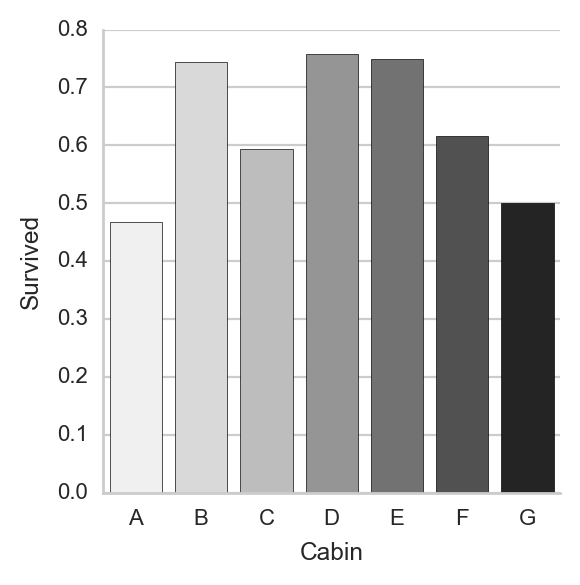

In [52]:
sns.factorplot('Cabin','Survived', data=titanic_cabin, order=['A','B','C','D','E','F','G'],
               kind='bar', size=3, palette='Greys', ci=False)

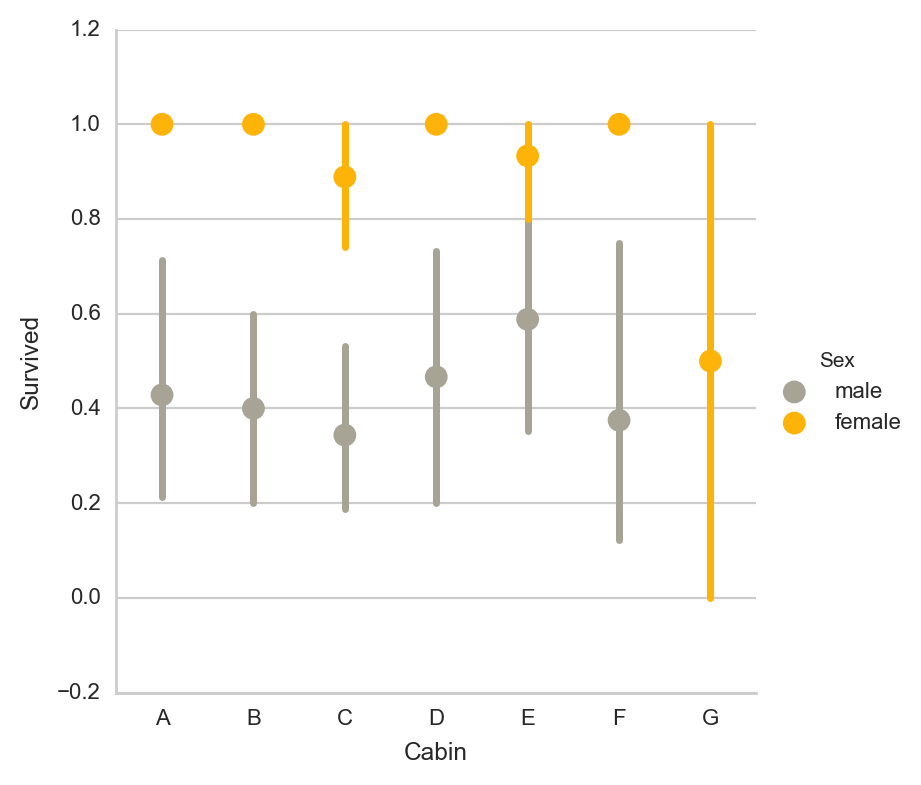

In [53]:
sns.factorplot("Cabin", "Survived", hue='Sex', order=['A','B','C','D','E','F','G'],
               hue_order=['male','female'], data=titanic_cabin, kind='point', join=False)

The smallest proportion of survivers was on deck A, passengers had best chance of survival on deck D. All women from decks A,B,D,F survived and they had smallest chance of survival on deck G, where there were no men. Men had the best chance of survival on deck E.

# Conclusion

Based on the analysis above we can say that the best chance for survival had:
- **woman travelling without family, in 1st or 2nd class**

The least chance of survival had:
- **man, travelling with family in 3rd class**

# Limitations

- The dataset contains only part of the Titanic passengers
- Some data is incomplete (age, cabin)
- We are not controlling for lurking variables that may have impact on survival


References:

[1] https://www.graphpad.com/guides/prism/6/statistics/index.htm?stat_qa_choosing_a_test_to_compare_.htm

[2] t-test table: http://snobear.colorado.edu/Markw//IntroHydro/12/statistics/testchart.pdf